In [1]:
import praw
import pandas as pd
import numpy as np
import datetime as dt
from praw.models import MoreComments
import nltk
nltk.download('vader_lexicon')
import nltk.sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from afinn import Afinn
import matplotlib.pyplot as plt
import seaborn as sns
from cryptocmd import CmcScraper
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Jeanette\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Creating a function to access the Reddit API

In [2]:
reddit = praw.Reddit(client_id='pn_XKPkNYIVniw', \
                     client_secret='So9Pt0QWBh7RCS9Lxd7S7hUeRjPboQ', \
                     user_agent='Blockchain_Economics')

The Reddit scrape

In [3]:
#I define a function to scrape Reddit posts for comments
def get_reddit_comments(cryptocurrency, testing = False):
    subreddit = reddit.subreddit('CryptoCurrency')
    
    comments = []
    subid = []
    treeid = []
    date = []
    
    results = subreddit.search(cryptocurrency, sort = 'top')
    i = 0
    for subidx, submission in enumerate(results):
        
        if testing:
            if i > 5:
                break
            i += 1
            
        try:
            comment_tree = submission.comments.list()
            for treeidx, top_lvl_comment in enumerate(comment_tree):
                
                if isinstance(top_lvl_comment, MoreComments):
                    continue
                
                subid.append(subidx)
                comments.append(top_lvl_comment.body)
                treeid.append(treeidx)
                date.append(top_lvl_comment.created_utc)
                
        except:
            pass
    df = pd.DataFrame({'submission': subid, 'comment_tree': treeid, 'comment': comments, 'date': date})
    df['date'] = pd.to_datetime(df['date'], unit = 's')
    df = df.set_index(['date'])
    df = df.sort_index()
    
    df['key'] = f'{cryptocurrency}'
    
    df.to_csv(f'{cryptocurrency}.csv', sep=';', encoding='utf-8-sig')
    
    return df

In [4]:
keys = ['Bitcoin', 'BTC', 'Ethereum', 'ETH', 'Dogecoin', 'DOGE',
        'Litecoin', 'LTC']

[get_reddit_comments(key) for key in keys]

[                     submission  comment_tree  \
 date                                            
 2017-09-10 05:55:38          76            51   
 2017-09-10 06:01:25          76            50   
 2017-09-10 06:02:13          76            17   
 2017-09-10 06:04:11          76             1   
 2017-09-10 06:07:28          76           145   
 ...                         ...           ...   
 2021-05-27 22:03:32          49           373   
 2021-05-27 22:49:53          49           411   
 2021-05-27 23:10:41          49           433   
 2021-05-28 02:49:23          49           358   
 2021-05-28 08:31:32          26           521   
 
                                                                comment  \
 date                                                                     
 2017-09-10 05:55:38                       And who the f*** are you? JK   
 2017-09-10 06:01:25                     Someone lost a lot of money...   
 2017-09-10 06:02:13  The Dotcom bubble was a th

Cleaning social media data

In [62]:
keys = ['Bitcoin', 'BTC', 'Ethereum', 'ETH', 'Dogecoin', 'DOGE',
        'Litecoin', 'LTC']

#Reading the csv files and creating dataframes
crypto_lists = [pd.read_csv(f'{key}.csv', sep=';') for key in keys]

#Concatenation of the dataframes for each person
crypto_lists = pd.concat(crypto_lists)

#Cleaning the date to only state the date of the day by removing the last part of the string, the time of the day
crypto_lists['date'] = crypto_lists['date'].str[0:10]

crypto_lists['date']= pd.to_datetime(crypto_lists['date'])
                             
period = (crypto_lists['date'] >= '2021-01-01') & (crypto_lists['date'] < '2021-05-01')

#Removes the observations beyond the period specified above
crypto_lists = crypto_lists.loc[period]
    
crypto_lists['key'] = crypto_lists['key'].replace('Bitcoin', 'bitcoin')\
                                           .replace('BTC', 'bitcoin')\
                                           .replace('Ethereum', 'ethereum')\
                                           .replace('ETH', 'ethereum')\
                                           .replace('Dogecoin', 'dogecoin')\
                                           .replace('DOGE', 'dogecoin')\
                                           .replace('Litecoin', 'litecoin')\
                                           .replace('LTC', 'litecoin')\

crypto_lists = crypto_lists.drop_duplicates(subset=['key', 'comment'], keep='first').sort_values('date')\
                            .reset_index().set_index('date').drop('index', axis=1)

crypto_lists

,submission,comment_tree,comment,key
date,,,,
2021-01-01,27,532,I used to use [localbitcoins.com](https://loca...,bitcoin
2021-01-01,25,532,I used to use [localbitcoins.com](https://loca...,ethereum
2021-01-01,27,539,Thank you! :),bitcoin
2021-01-05,64,194,"I think i got 2 times 100k, i guess i found it...",ethereum
2021-01-05,64,158,"Just out of curiosity, how did you get so much...",ethereum
...,...,...,...,...
2021-04-30,0,261,Also be aware that scammers have some pretty g...,ethereum
2021-04-30,0,473,Wallets hold keys not coins.\n“The actual wall...,ethereum
2021-04-30,0,543,This is fascinating stuff. Thanks for the insi...,ethereum


Scraping cryptocurrency data

In [63]:
#Insert cryptocurrency symbol to scrape
ccy = 'DOGE'

#I have manually written each symbol key, as it is not capable to run a list as input
scraper = CmcScraper(ccy, "01-01-2021", "30-04-2021")

#Exporting raw data
headers, data = scraper.get_data()

#Pulling data in a json format
json_data = scraper.get_data("json")

#Exporting the data to a csv file
scraper.export("csv")

#Adding identifiers for each cryptocurrency
temporary = pd.read_csv(f'{ccy}_01-01-2021_30-04-2021.csv', sep=',')
temporary['ccy'] = ccy
temporary.to_csv(f'{ccy}_01-01-2021_30-04-2021.csv', index=False)

Cleaning cryptocurrency data

In [64]:
symbol_keys = ['BTC', 'ETH', 'DOGE', 'LTC']

crypto_prices = [pd.read_csv(f'{key}_01-01-2021_30-04-2021.csv', sep=',') for key in symbol_keys]

crypto_prices = pd.concat(crypto_prices)

crypto_prices['date'] = pd.to_datetime(crypto_prices['Date'], format='%d-%m-%Y')

#Changing the "Close" variable to a numeric data type
crypto_prices['Close'] = pd.to_numeric(crypto_prices['Close'],errors='coerce')

#Log-transformation
crypto_prices['Close'] = np.log(crypto_prices['Close'])

#Note the date as the index and removing columns not used
crypto_prices = crypto_prices.sort_values('date').reset_index().set_index('date')\
.drop('index', axis=1).drop('Date', axis=1).drop('Open', axis=1).drop('High', axis=1)\
.drop('Low', axis=1).drop('Volume', axis=1).drop('Market Cap', axis=1)

#Renaming data for the keys to match the social media data
crypto_prices['key'] = crypto_prices['ccy'].replace('BTC', 'bitcoin')\
                                           .replace('ETH', 'ethereum')\
                                           .replace('DOGE', 'dogecoin')\
                                           .replace('LTC', 'litecoin')\

crypto_prices

,Close,ccy,key
date,,,
2021-01-01,6.593548,ETH,ethereum
2021-01-01,-5.169931,DOGE,dogecoin
2021-01-01,10.287870,BTC,bitcoin
2021-01-01,4.838108,LTC,litecoin
2021-01-02,10.377460,BTC,bitcoin
...,...,...,...
2021-04-29,5.543556,LTC,litecoin
2021-04-30,5.602735,LTC,litecoin
2021-04-30,-1.086009,DOGE,dogecoin


Implementation of VADER sentiment analysis

In [65]:
#Calling the VADER sentiment function
sid = SentimentIntensityAnalyzer()

crypto_lists['vader_scores'] = crypto_lists['comment'].apply(lambda comment: sid.polarity_scores(comment))

crypto_lists['vader']  = crypto_lists['vader_scores'].apply(lambda score_dict: score_dict['compound'])

#crypto_lists.head()

In [77]:
crypto_lists.groupby('key')['vader'].describe()

,count,mean,std,min,25%,50%,75%,max
key,,,,,,,,
bitcoin,35804.0,0.183741,0.464549,-0.9999,0.0,0.0772,0.5719,0.9990
dogecoin,28603.0,0.185865,0.471752,-0.9978,0.0,0.1134,0.5859,0.9994
ethereum,29204.0,0.237963,0.456504,-0.9936,0.0,0.2401,0.6341,0.9990
litecoin,12083.0,0.259966,0.458422,-0.9869,0.0,0.2979,0.6546,0.9994


Implementation of AFINN sentiment analysis

In [66]:
#Defining the AFINN sentiment analysis to examine English and include emojies
afinn = Afinn(language='en', emoticons=True)

#AFINN is run on the comments from Reddit whcih creates a new column with scores
crypto_lists['afinn'] = [afinn.score(comment) for comment in crypto_lists.comment]

#crypto_lists

Graphical comparison of AFINN and VADER

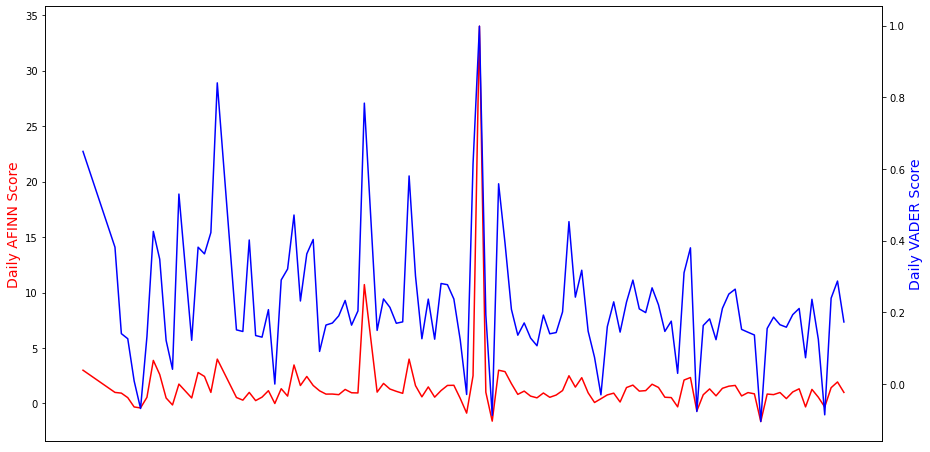

In [67]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(1,1,1)
#Calling the "twinx" to create a secondary y-axis
ax2 = ax.twinx()

#Plotting the data and assigning them labels
ax.plot(crypto_lists.loc[crypto_lists['key'] == 'bitcoin']\
        .groupby('date')['afinn'].mean(), color = 'red', label = 'Bitcoin_AFINN')

#Creating a plot with different y-axis using second axis object
ax2.plot(crypto_lists.loc[crypto_lists['key'] == 'bitcoin']\
         .groupby('date')['vader'].mean(), color = 'blue', label = 'Bitcoin_VADER')

ax.set_xticks([])
ax.set_ylabel("Daily AFINN Score",color="red",fontsize=14)
ax2.set_ylabel("Daily VADER Score",color="blue",fontsize=14)

#Saves the plot as a file
fig.savefig('AFINN_vs_VADER.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

The daily frequency of Reddit comments

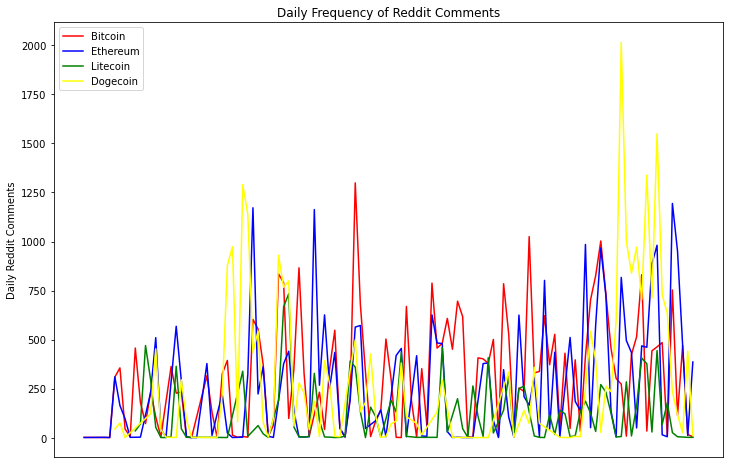

In [68]:
#Initiates figure
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

#Plotting the frequency count and assigning them labels
ax.plot(crypto_lists.loc[crypto_lists['key'] == 'bitcoin']\
        .groupby('date')['comment'].count(), color = 'red', label = 'Bitcoin')
ax.plot(crypto_lists.loc[crypto_lists['key'] == 'ethereum']\
        .groupby('date')['comment'].count(), color = 'blue', label = 'Ethereum')
ax.plot(crypto_lists.loc[crypto_lists['key'] == 'litecoin']\
       .groupby('date')['comment'].count(), color = 'green', label = 'Litecoin')
ax.plot(crypto_lists.loc[crypto_lists['key'] == 'dogecoin']\
       .groupby('date')['comment'].count(), color = 'yellow', label = 'Dogecoin')

#Customizing the design of the axis, their labels and the legends
ax.set_xticks([])
ax.set_ylabel('Daily Reddit Comments')
ax.set_title('Daily Frequency of Reddit Comments')
ax.legend(loc = 'upper left', frameon = True)

#Saves the plot as a file
fig.savefig('Comment_frequency.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

Creating a dataframe for each cryptocurrency and merging closing prices on it

In [69]:
#Assigning what data to use
data = [crypto_lists.loc[crypto_lists['key'] == 'bitcoin'].groupby('date')['vader'].mean()\
        , crypto_lists.loc[crypto_lists['key'] == 'bitcoin']['key']]
headers = ["vader", "key"]
#Creates a temporary dataframe
temp_btc = pd.concat(data, axis=1, keys=headers).drop_duplicates(subset=['vader'], keep='first')
#Merges the sentiment scores and closing prices, while differentiating the values
btc = pd.merge(temp_btc, crypto_prices, on=['date', 'key'], how='inner')\
.drop('ccy', axis=1).drop('key', axis=1).diff().dropna(how='any')

data = [crypto_lists.loc[crypto_lists['key'] == 'ethereum'].groupby('date')['vader'].mean()\
        , crypto_lists.loc[crypto_lists['key'] == 'ethereum']['key']]
headers = ["vader", "key"]
temp_eth = pd.concat(data, axis=1, keys=headers).drop_duplicates(subset=['vader'], keep='first')
eth = pd.merge(temp_eth, crypto_prices, on=['date', 'key'], how='inner')\
.drop('ccy', axis=1).drop('key', axis=1).diff().dropna(how='any')

data = [crypto_lists.loc[crypto_lists['key'] == 'litecoin'].groupby('date')['vader'].mean()\
        , crypto_lists.loc[crypto_lists['key'] == 'litecoin']['key']]
headers = ["vader", "key"]
temp_ltc = pd.concat(data, axis=1, keys=headers).drop_duplicates(subset=['vader'], keep='first')
ltc = pd.merge(temp_ltc, crypto_prices, on=['date', 'key'], how='inner')\
.drop('ccy', axis=1).drop('key', axis=1).diff().dropna(how='any')

data = [crypto_lists.loc[crypto_lists['key'] == 'dogecoin'].groupby('date')['vader'].mean()\
        , crypto_lists.loc[crypto_lists['key'] == 'dogecoin']['key']]
headers = ["vader", "key"]
temp_doge = pd.concat(data, axis=1, keys=headers).drop_duplicates(subset=['vader'], keep='first')
doge = pd.merge(temp_doge, crypto_prices, on=['date', 'key'], how='inner')\
.drop('ccy', axis=1).drop('key', axis=1).diff().dropna(how='any')

btc

,vader,Close
date,,
2021-01-06,-0.267200,0.226045
2021-01-07,-0.241186,0.066871
2021-01-08,-0.014116,0.035593
2021-01-09,-0.117799,-0.013401
2021-01-10,-0.076858,-0.048301
...,...,...
2021-04-26,-0.111559,0.097480
2021-04-27,-0.210714,0.018548
2021-04-28,0.325360,-0.003794


Saving the new dataframes as a CSV file

In [70]:
btc.to_csv('BTC_VADER_and_PRICE.csv', index=True)
eth.to_csv('ETH_VADER_and_PRICE.csv', index=True)
ltc.to_csv('LTC_VADER_and_PRICE.csv', index=True)
doge.to_csv('DOGE_VADER_and_PRICE.csv', index=True)

Implementation of Granger's Causality test

In [71]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    

    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

granger_btc = grangers_causation_matrix(btc, ['Close', 'vader'])
granger_eth = grangers_causation_matrix(eth, ['Close', 'vader'])
granger_ltc = grangers_causation_matrix(ltc, ['Close', 'vader'])
granger_doge = grangers_causation_matrix(doge, ['Close', 'vader'])
print(granger_btc, granger_eth, granger_ltc, granger_doge)

         Close_x  vader_x
Close_y   1.0000   0.0678
vader_y   0.0133   1.0000          Close_x  vader_x
Close_y   1.0000    0.265
vader_y   0.2363    1.000          Close_x  vader_x
Close_y   1.0000   0.0547
vader_y   0.0963   1.0000          Close_x  vader_x
Close_y   1.0000    0.003
vader_y   0.0495    1.000


Cointegration test

In [72]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(btc)
cointegration_test(eth)
cointegration_test(ltc)
cointegration_test(doge)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
vader  ::  55.82     > 12.3212   =>   True
Close  ::  15.27     > 4.1296    =>   True
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
vader  ::  63.45     > 12.3212   =>   True
Close  ::  19.19     > 4.1296    =>   True
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
vader  ::  56.83     > 12.3212   =>   True
Close  ::  9.52      > 4.1296    =>   True
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
vader  ::  55.37     > 12.3212   =>   True
Close  ::  11.23     > 4.1296    =>   True
